This Notebook explores a possible modeling approach for the Instacart dataset. 

## Assumptions

- Products do not change, but users change
  - e.g. Pepsi was Pepsi in 2017 and in 2018. However, I may have liked Pepsi in 2017, but I am now moved on to a healthier drink
- Time to repurchase matters
  - e.g. Suppose Product A is repurchased almost every "week", and Product B is repurchased almost every "year". These two repurchase behaviors are not the same.
- Users and products have their inherent biases
  - e.g. Some users are just heavy users to begin with. Some products are just poopular to begin with.
- A user can be expressed with a mixture of static and dynamic states

## Data Processing

1. Group by user
1. Calculate a moving average (with a window size of T) of ordered products e.g.
  1. For a user with a order history of `-11--1----`
  1. We apply a moving average of T=4
  1. `-11-`, `11--`, `1--1`, `--1-`, `-1--`, `1---`, `----`
  1. 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.0
1. NOTE: Each user will have a different length of data points
1. Create a data variable `Y` with an index order of `user_id -> time_stamp -> product_id: <moving average>`
1. Create a data variable `Z` with an index order of `product_id -> user_id -> time_stamp: <moving average>` NOTE: `Z` is a transpose of `Y`

## Objective Function

In [1]:
%%latex
\begin{align}
&\min_{\mathbf{u}, \mathbf{v}, \alpha} \sum_{i, t_i, j \in \mathcal{D}} ( y_{i,t_i,j} - \mathbf{u}_{i,t_i}^T \mathbf{v}_{j} - \alpha_i - \alpha_j )^2 + C_u ||\mathbf{u}_{i,t_i}-\mathbf{u}_{i,t_i-1}||^2 + C_v ||\mathbf{v}_{j}||^2  \\
&\text{where}\quad \mathbf{u}_{i,0} = 0
\end{align}

<IPython.core.display.Latex object>

## Iterative Solution

In [2]:
%%latex
\begin{align}
\mathbf{u}_{i, t_i} &= (\mathbf{V}_{i,t_i}^T \mathbf{V}_{i,t_i} + C_u \mathbf{I})^{-1} (\mathbf{V}_{i,t_i}^T \mathbf{y}_{i,t_i} + C_u \mathbf{u}_{i, t_i-1})\\
\mathbf{v}_j &= (\mathbf{U}_j^T \mathbf{U}_j + C_v \mathbf{I})^{-1}\mathbf{U}_j^T \mathbf{y}_j\\
\alpha_i &= \text{np.mean}(\mathbf{y}_i - \mathbf{u}_i^T \mathbf{V}_i)\\
\alpha_j &= \text{np.mean}(\mathbf{y}_j - \mathbf{U}_j^T \mathbf{v}_j)
\end{align}

<IPython.core.display.Latex object>

## Implementation

In [3]:
from __future__ import print_function
from pymongo import MongoClient
from collections import Counter
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# parameters
n_max = 20000
m_max = 100
C_u = 0.01
C_v = 0.01
T = 5
D = 3

In [5]:
client = MongoClient()
db = client.instacart

In [6]:
user_lst = []
prod_lst = []
for doc in db.orders.find().limit(n_max):
    user_lst.append(doc["user_id"])
    prod_lst += [x for y in doc["orders"] for x in y["products"]]
prod_cnt = Counter(prod_lst)

In [7]:
user_set = {x for x in user_lst}
prod_set = {x for x, cnt in prod_cnt.most_common(m_max)}

In [8]:
# Construct data variables: Y & Z

Y = {} # Y[i][t][j]
Z = {} # Z[j][i][t]
for doc in db.orders.find().limit(n_max):
    i = doc["user_id"]
    orders = doc["orders"]
    orders = [x for x in orders if len(prod_set.intersection(x["products"]))>0]
    if len(orders) < T:
        user_set.discard(i)
        continue
    t_end = max(1, len(orders)-T-1)
    for t in range(t_end):
        p = Counter([x for y in orders[t:t+T] for x in y["products"]
                    if x in prod_set])
        for j, y_itj_unnorm in p.items():
            y_itj = (y_itj_unnorm+0.0)/T
            if i not in Y:
                Y[i] = {}
            if t not in Y[i]:
                Y[i][t] = {}
            if j not in Z:
                Z[j] = {}
            if i not in Z[j]:
                Z[j][i] = {}
            Y[i][t][j] = y_itj
            Z[j][i][t] = y_itj

In [9]:
# Initialize parameters: A_u, A_v, U, V

A_u = {}
A_v = {}
U = {} # U[i][t]
V = {} # V[j]
np.random.seed(1)
for i, y_i in Y.items():
    U[i] = {}
    A_u[i] = 0
    for t, y_it in y_i.items():
        U[i][t] = np.random.rand(D)/D
for j in prod_set:
    A_v[j] = 0
    V[j] = np.random.rand(D)/D

In [10]:
def construct_vyit(y_it, V, A_u_i, A_v, mode=0):
    j_seq = [j for j in y_it.keys()]
    n_it = len(j_seq)
    y_it_adj = np.zeros(n_it)
    V_it = np.zeros((n_it, D))
    for j_idx, j in enumerate(j_seq):
        y_it_adj[j_idx] = y_it[j] - A_v[j]
        if mode==1:
            y_it_adj[j_idx] -= A_u_i
        V_it[j_idx,:] = V[j]
    return y_it_adj, V_it

def update_alpha_u(Y, U, V, A_u, A_v):
    for i, u_i in U.items():
        n_cum = 0
        a_cum = 0
        y_i = Y[i]
        for t in range(len(u_i.keys())):
            y_it_adj, V_it = construct_vyit(y_i[t], V, A_u[i], A_v)
            a_cum += np.sum(y_it_adj - np.dot(V_it, u_i[t]))
            n_cum += y_it_adj.shape[0]
        A_u[i] = a_cum/n_cum
        
def update_u_it(y_i, u_i, V, t, A_u_i, A_v):
    u_prev = np.zeros(D)
    if t > 0:
        u_prev = u_i[t-1]
    I = np.diag(np.ones(D))
    y_it_adj, V_it = construct_vyit(y_i[t], V, A_u_i, A_v, 1)
    out1 = np.linalg.inv(np.dot(V_it.T, V_it) + C_u * I)
    out2 = np.dot(V_it.T, y_it_adj) + C_u * u_prev
    return np.dot(out1, out2)
    
def update_u(Y, U, V, A_u, A_v):
    for i, y_i in Y.items():
        for t in range(len(U[i].keys())):
            U[i][t] = update_u_it(y_i, U[i], V, t, A_u[i], A_v)

def construct_yuj(z_j, U, v_j, A_u, A_v_j, mode=0):
    y_j_adj = []
    for i, z_ji in z_j.items():
        for t, z_jit in z_ji.items():
            val = z_jit - A_u[i]
            if mode == 1:
                val -= A_v_j
            y_j_adj.append(val)
    n_j = len(y_j_adj)
    y_j_adj = np.array(y_j_adj)                    
    U_j = np.zeros((n_j, D))
    u_idx = 0
    for i, z_ji in z_j.items():
        for t, z_jit in z_ji.items():
            U_j[u_idx,:] = U[i][t]
            u_idx += 1
    return y_j_adj, U_j
            
def update_alpha_v(Z, U, V, A_u, A_v):
    for j in V.keys():
        y_j_adj, U_j = construct_yuj(Z[j], U, V[j], A_u, A_v[j])
        A_v[j] = np.mean(y_j_adj - np.dot(U_j, V[j]))
            
def update_v(Z, U, V, A_u, A_v):
    I = np.diag(np.ones(D))
    for j, z_j in Z.items():
        y_j_adj, U_j = construct_yuj(Z[j], U, V[j], A_u, A_v[j], 1)
        out1 = np.linalg.inv(np.dot(U_j.T, U_j)+C_v*I)
        out2 = np.dot(U_j.T, y_j_adj)
        V[j] = np.dot(out1, out2)
        
def loss_function(Y, U, V, A_u, A_v):
    loss = 0
    for i, y_i in Y.items():
        A_u_i = A_u[i]
        for t, y_it in y_i.items():
            u_prev = np.zeros(D)
            if t > 0:
                u_prev = U[i][t-1]
            dU = (U[i][t] - u_prev)
            dU_norm = np.dot(dU.T, dU)
            loss += C_u * dU_norm
            for j, y_itj in y_it.items():
                loss += (y_itj - np.dot(U[i][t].T, V[j]) - A_u_i - A_v[j])**2
    for j, v_j in V.items():
        loss += C_v * np.dot(v_j.T, v_j)
    return loss

In [11]:
num_iteration = 50
loss = []
for k in tqdm(range(num_iteration)):
    update_u(Y, U, V, A_u, A_v)
    update_v(Z, U, V, A_u, A_v)
    update_alpha_u(Y, U, V, A_u, A_v)
    update_alpha_v(Z, U, V, A_u, A_v)
    loss.append(loss_function(Y, U, V, A_u, A_v))

100%|██████████| 50/50 [20:32<00:00, 24.66s/it]


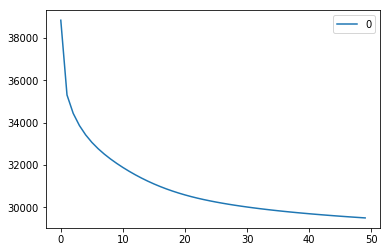

In [12]:
pd.DataFrame(loss).plot()

In [13]:
V_df = pd.DataFrame([[k] + v.tolist() for k, v in V.items()])
V_df

,0,1,2,3
0,8424 Broccoli Crown,0.054784,0.150774,0.147868
1,39928 Organic Kiwi,0.226629,0.145246,0.070736
2,25890 Boneless Skinless Chicken Breasts,0.145724,0.062593,0.265831
3,45007 Organic Zucchini,0.169416,0.054623,0.149045
4,45066 Honeycrisp Apple,-0.091362,0.528157,-0.017482
5,13176 Bag of Organic Bananas,0.923411,-0.096909,0.123439
6,27344 Uncured Genoa Salami,0.080002,0.223444,0.056134
7,40604 Feta Cheese Crumbles,0.085715,0.061704,0.089233
8,39877 Organic Granny Smith Apple,0.186220,0.247489,0.125712
9,17794 Carrots,0.141490,0.066806,0.082166


In [14]:
A_v

{u'10749 Organic Red Bell Pepper': 0.050192656699400831,
 u'11520 Large Alfresco Eggs': -0.091014738140433149,
 u'12341 Hass Avocados': -0.066349759475540018,
 u'13176 Bag of Organic Bananas': -0.14117112401249518,
 u'15290 Orange Bell Pepper': -0.019938668931750513,
 u'16759 Organic Carrot Bunch': 0.064133337402765458,
 u'16797 Strawberries': 0.033966407817633305,
 u'17794 Carrots': 0.083649631847908565,
 u'18465 Organic Grade A Free Range Large Brown Eggs': 0.023147239546282169,
 u'19057 Organic Large Extra Fancy Fuji Apple': -0.10970885912535359,
 u'196 Soda': -0.2099767447984027,
 u'19660 Spring Water': -0.19186607023455035,
 u'20114 Jalapeno Peppers': 0.057550573978476079,
 u'20995 Organic Broccoli Florets': 0.1158761515733783,
 u'21137 Organic Strawberries': -0.010549474183755934,
 u'21616 Organic Baby Arugula': 0.064948449496402313,
 u'21709 Sparkling Lemon Water': -0.027861000539780603,
 u'21903 Organic Baby Spinach': -0.027536087277950441,
 u'21938 Green Bell Pepper': 0.060568

In [49]:
user_lst = list(user_set)
user_id = user_lst[0]
print(user_id)
print(U[user_id])

114787
{0: array([ 0.68035208,  0.94697398,  0.20173927]), 1: array([ 0.68641371,  0.90004831, -0.01173592]), 2: array([ 0.68969812,  0.89456627, -0.03067007]), 3: array([ 0.69003281,  0.89401857, -0.03241085]), 4: array([ 0.68831806,  0.90980109,  0.00821807]), 5: array([ 0.69997115,  0.84623454, -0.14171401]), 6: array([ 0.70923199,  0.81146539, -0.2289577 ]), 7: array([ 0.89154909,  0.85077135,  0.06942863]), 8: array([ 0.88575055,  0.87080232,  0.12774959]), 9: array([ 1.06840143,  0.89862356,  0.39871644]), 10: array([ 1.28606459,  1.22843006,  0.72225141]), 11: array([ 1.23192074,  1.48470966,  1.39439487]), 12: array([ 1.30827702,  1.00829607,  0.22357122]), 13: array([ 1.12995387,  1.07830568,  0.12014195]), 14: array([ 0.91526628,  1.23903562,  0.23638125])}


In [50]:
Y[user_id]

{0: {u'13176 Bag of Organic Bananas': 0.4,
  u'26604 Organic Blackberries': 0.2,
  u'27104 Fresh Cauliflower': 0.2,
  u'45007 Organic Zucchini': 0.4,
  u'47209 Organic Hass Avocado': 0.6},
 1: {u'13176 Bag of Organic Bananas': 0.4,
  u'26604 Organic Blackberries': 0.2,
  u'27104 Fresh Cauliflower': 0.2,
  u'42736 Unsalted Butter': 0.2,
  u'45007 Organic Zucchini': 0.2,
  u'47209 Organic Hass Avocado': 0.6},
 2: {u'13176 Bag of Organic Bananas': 0.4,
  u'26604 Organic Blackberries': 0.2,
  u'27104 Fresh Cauliflower': 0.2,
  u'42736 Unsalted Butter': 0.2,
  u'45007 Organic Zucchini': 0.2,
  u'47209 Organic Hass Avocado': 0.6},
 3: {u'13176 Bag of Organic Bananas': 0.4,
  u'26604 Organic Blackberries': 0.2,
  u'27104 Fresh Cauliflower': 0.2,
  u'42736 Unsalted Butter': 0.2,
  u'45007 Organic Zucchini': 0.2,
  u'47209 Organic Hass Avocado': 0.6},
 4: {u'13176 Bag of Organic Bananas': 0.4,
  u'26604 Organic Blackberries': 0.2,
  u'42736 Unsalted Butter': 0.2,
  u'47209 Organic Hass Avocado'

In [52]:
history = list(set([x for t, y_it in Y[user_id].items() for x in y_it.keys()]))
t_max = np.max(U[i].keys())
out = Counter()
for j in history:
    score_j = np.dot(U[i][t_max].T, V[j]) + A_v[j] + A_u[i]
    out[j] = score_j
out.most_common()

[(u'13176 Bag of Organic Bananas', 0.79321793413438169),
 (u'26604 Organic Blackberries', 0.48419226839854052),
 (u'45007 Organic Zucchini', 0.33786871738236185),
 (u'24184 Red Peppers', 0.32246716423667671),
 (u'47209 Organic Hass Avocado', 0.25840757251959473),
 (u'27104 Fresh Cauliflower', 0.23508608334330011),
 (u'16759 Organic Carrot Bunch', 0.19793981057473586),
 (u'42736 Unsalted Butter', 0.10797090964520112),
 (u'31506 Extra Virgin Olive Oil', 0.10026752584311954)]

In [18]:
def get_similar_products(j, top_k):
    dist = Counter()
    A_v_j = A_v[j]
    v_j = V[j]
    for k, v_k in V.items():
        if k == j:
            continue
        score = np.dot(v_j, v_k) + A_v_j*A_v[k]
        dist[k] = score
    return dist.most_common(top_k)

In [19]:
get_similar_products("24852 Banana", 10)

[(u'19660 Spring Water', 0.77348461620947839),
 (u'38689 Organic Reduced Fat Milk', 0.6048336599240538),
 (u'24838 Unsweetened Almondmilk', 0.59559582669724132),
 (u'45066 Honeycrisp Apple', 0.41892970725923068),
 (u'35221 Lime Sparkling Water', 0.37463322154428597),
 (u'21709 Sparkling Lemon Water', 0.37010558840781016),
 (u'43352 Raspberries', 0.35525002461366018),
 (u'27966 Organic Raspberries', 0.34660177192376945),
 (u'21137 Organic Strawberries', 0.32306450755621952),
 (u'12341 Hass Avocados', 0.29639458184966405)]

In [20]:
get_similar_products("33731 Grated Parmesan", 10)

[(u'38689 Organic Reduced Fat Milk', 0.066170809146371926),
 (u'47766 Organic Avocado', 0.056818401066065088),
 (u'4210 Whole Milk', 0.053914640033501472),
 (u'13176 Bag of Organic Bananas', 0.049579661415934263),
 (u'47209 Organic Hass Avocado', 0.04859172966436795),
 (u'24852 Banana', 0.046262107439836567),
 (u'33198 Sparkling Natural Mineral Water', 0.044545248559524853),
 (u'5450 Small Hass Avocado', 0.042134215308631748),
 (u'8277 Apple Honeycrisp Organic', 0.040841013050168226),
 (u'27966 Organic Raspberries', 0.039617568697132316)]

In [21]:
get_similar_products("13176 Bag of Organic Bananas", 10)

[(u'27845 Organic Whole Milk', 0.89384404430703235),
 (u'23909 2% Reduced Fat Milk', 0.61849261205401462),
 (u'4210 Whole Milk', 0.52656139244064804),
 (u'11520 Large Alfresco Eggs', 0.46869910225243544),
 (u'27086 Half & Half', 0.43974863607861647),
 (u'33198 Sparkling Natural Mineral Water', 0.41377700501493364),
 (u'28204 Organic Fuji Apple', 0.39990318893455806),
 (u'5077 100% Whole Wheat Bread', 0.36744895080782497),
 (u'47766 Organic Avocado', 0.33870387808490621),
 (u'3957 100% Raw Coconut Water', 0.33673922403152984)]

In [26]:
get_similar_products("27344 Uncured Genoa Salami", 10)

[(u'38689 Organic Reduced Fat Milk', 0.22524677825322914),
 (u'47766 Organic Avocado', 0.16139361971069274),
 (u'24852 Banana', 0.15799482713885998),
 (u'47209 Organic Hass Avocado', 0.13090675985421382),
 (u'24838 Unsweetened Almondmilk', 0.11534078272394882),
 (u'45066 Honeycrisp Apple', 0.1099462127466754),
 (u'27966 Organic Raspberries', 0.10748320117786281),
 (u'19660 Spring Water', 0.10733451563311086),
 (u'5450 Small Hass Avocado', 0.10406177377349443),
 (u'4210 Whole Milk', 0.10074121840284408)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131ccd590>]], dtype=object)

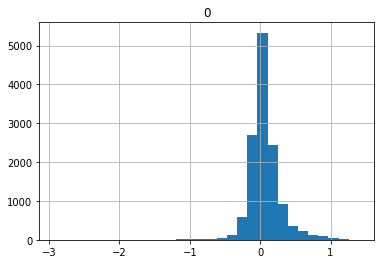

In [30]:
pd.DataFrame([v for k, v in A_u.items()]).hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131e39e90>]], dtype=object)

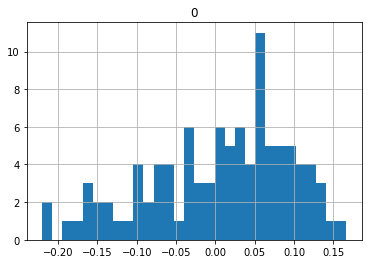

In [31]:
pd.DataFrame([v for k, v in A_v.items()]).hist(bins=30)

In [47]:
user_id, _ = Counter(A_u).most_common()[-3]
Y[user_id]

{0: {u'27845 Organic Whole Milk': 1.0},
 1: {u'27845 Organic Whole Milk': 1.0},
 2: {u'27845 Organic Whole Milk': 1.0},
 3: {u'27845 Organic Whole Milk': 1.0},
 4: {u'27845 Organic Whole Milk': 1.0},
 5: {u'27845 Organic Whole Milk': 1.0},
 6: {u'27845 Organic Whole Milk': 1.0},
 7: {u'27845 Organic Whole Milk': 1.0},
 8: {u'27845 Organic Whole Milk': 1.0},
 9: {u'27845 Organic Whole Milk': 1.0},
 10: {u'27845 Organic Whole Milk': 1.0},
 11: {u'27845 Organic Whole Milk': 1.0},
 12: {u'27845 Organic Whole Milk': 1.0},
 13: {u'27845 Organic Whole Milk': 1.0},
 14: {u'13176 Bag of Organic Bananas': 0.2, u'27845 Organic Whole Milk': 0.8}}

## Future Work (or Potential Extensions)

- You can use this model as-is for recommendation tasks
- User latent features can be dynamically updated with a simple solution
- In production, we need to maintain two additional tables: User and Product latent features
- User latent feature table will be dynamically updated every time a user purhcases
- Both tables will be periodically updated with a batch learning
- Extracted latent features can be additional features for other modeling work
- Divide and conquer can be tried as well -> if there are any clear user product segmentations
- Again, we need to constantly think why this model. If the model doesn't fit to the business objectives, then give it up